## 시계열 데이터
- 한글 헤더 읽기 EUC_KR

In [105]:
import matplotlib.pyplot as plt

In [2]:
with open("data.csv", "rt", encoding="EUC_KR") as fr:
    lines = fr.readlines()

n_lines = ["연,월,일,기온,품질,균질\n"] + lines[5:]
n_lines = map(lambda v: v.replace('/', ','), n_lines)
result = "".join(n_lines).strip()

with open("new_data.csv", "wt", encoding="utf-8") as fw:
    fw.write(result)

In [88]:
import pandas as pd
df = pd.read_csv('new_data.csv', encoding="utf-8")
df.shape

(4018, 6)

In [191]:
df[:5]

,연,월,일,기온,품질,균질
0,2006,1,1,3.6,8,1
1,2006,1,2,4.0,8,1
2,2006,1,3,3.7,8,1
3,2006,1,4,4.0,8,1
4,2006,1,5,3.6,8,1


### 일별 평균 기온

In [6]:
md = {}
for i, row in df.iterrows():
    m, d, v = (int(row['월']), int(row['일']), float(row['기온']))
    key = str(m) + "/" + str(d)
    if not(key in md): md[key] = []
    md[key] += [v]

# 날짜별 평균 구하기 ---(*3)
avs = {}
for key in md:
    v = avs[key] = sum(md[key]) / len(md[key]) # ---(*4)
    print("{0} : {1}".format(key, v))

1/1 : 6.0
1/2 : 6.545454545454546
1/3 : 6.145454545454546
1/4 : 6.1
1/5 : 6.4818181818181815
1/6 : 6.663636363636363
1/7 : 6.290909090909091
1/8 : 6.718181818181818
1/9 : 6.6000000000000005
1/10 : 6.0636363636363635
1/11 : 5.972727272727272
1/12 : 5.045454545454546
1/13 : 5.427272727272728
1/14 : 5.090909090909092
1/15 : 5.4363636363636365
1/16 : 5.654545454545454
1/17 : 5.627272727272726
1/18 : 5.045454545454546
1/19 : 6.0636363636363635
1/20 : 5.6909090909090905
1/21 : 5.6
1/22 : 5.5636363636363635
1/23 : 5.890909090909091
1/24 : 5.4818181818181815
1/25 : 6.0
1/26 : 6.027272727272727
1/27 : 6.363636363636363
1/28 : 6.5
1/29 : 6.281818181818181
1/30 : 6.763636363636365
1/31 : 6.754545454545453
2/1 : 6.309090909090909
2/2 : 6.663636363636363
2/3 : 6.363636363636363
2/4 : 5.800000000000001
2/5 : 5.790909090909091
2/6 : 5.318181818181818
2/7 : 6.1909090909090905
2/8 : 5.645454545454545
2/9 : 5.754545454545455
2/10 : 6.627272727272726
2/11 : 5.618181818181818
2/12 : 5.690909090909091
2/13

In [7]:
avs["11/4"]

15.281818181818181

### 월별 평균 기온

In [8]:
import matplotlib.pyplot as plt
g = df.groupby(['월'])["기온"]
gg = g.sum() / g.count()
# 결과 출력하기 ---(*3)
print(gg)
gg.plot()
plt.savefig("tem-month-avg.png")
plt.show()

월
1      5.996481
2      6.598714
3     10.017009
4     14.481515
5     19.607918
6     22.544848
7     26.422287
8     27.887097
9     24.360303
10    19.155132
11    13.484545
12     8.653079
Name: 기온, dtype: float64


<Figure size 640x480 with 1 Axes>

### 머신러닝을 이용한 예측
- 2015년 이전 데이터로 학습
- 2016년 데이터로 테스트
- 이전 n일의 데이터를 기반으로 다음날 기온을 예측
- 선형 모델 사용

In [629]:
from sklearn.linear_model import LinearRegression

train_year_bool = (df["연"] <= 2015)
test_year_bool = (df["연"] >= 2016)

In [630]:
len(train_year_bool), len(test_year_bool)

(4018, 4018)

In [631]:
type(test_year_bool)

pandas.core.series.Series

In [632]:
# 시리즈 입력, 리스트 리턴
def make_data(data, n_steps):
    x = []
    y = []
    temps = list(data["기온"])
    for i in range(len(temps)):
        if i < n_steps: continue
        y.append(temps[i])
        xa = []
        for p in range(n_steps):
            d = i + p - n_steps
            xa.append(temps[d])
        x.append(xa)
    return x, y

In [633]:
n_steps = 3
train_x, train_y = make_data(df[train_year_bool], n_steps)
test_x, test_y = make_data(df[test_year_bool], n_steps)

In [634]:
len(train_x), len(test_x)

(3649, 363)

In [572]:
len(train_y), len(test_y)

(3649, 363)

In [573]:
train_x

[[3.6, 4.0, 3.7],
 [4.0, 3.7, 4.0],
 [3.7, 4.0, 3.6],
 [4.0, 3.6, 2.1],
 [3.6, 2.1, 2.8],
 [2.1, 2.8, 4.2],
 [2.8, 4.2, 3.7],
 [4.2, 3.7, 4.3],
 [3.7, 4.3, 6.1],
 [4.3, 6.1, 6.1],
 [6.1, 6.1, 4.0],
 [6.1, 4.0, 6.6],
 [4.0, 6.6, 10.7],
 [6.6, 10.7, 9.0],
 [10.7, 9.0, 8.0],
 [9.0, 8.0, 5.6],
 [8.0, 5.6, 4.2],
 [5.6, 4.2, 4.0],
 [4.2, 4.0, 1.3],
 [4.0, 1.3, 3.1],
 [1.3, 3.1, 2.5],
 [3.1, 2.5, 4.4],
 [2.5, 4.4, 5.5],
 [4.4, 5.5, 6.0],
 [5.5, 6.0, 6.8],
 [6.0, 6.8, 5.5],
 [6.8, 5.5, 6.0],
 [5.5, 6.0, 8.4],
 [6.0, 8.4, 7.1],
 [8.4, 7.1, 5.7],
 [7.1, 5.7, 7.8],
 [5.7, 7.8, 6.0],
 [7.8, 6.0, 1.6],
 [6.0, 1.6, 1.9],
 [1.6, 1.9, 2.0],
 [1.9, 2.0, 3.6],
 [2.0, 3.6, 7.9],
 [3.6, 7.9, 4.6],
 [7.9, 4.6, 5.6],
 [4.6, 5.6, 7.5],
 [5.6, 7.5, 4.6],
 [7.5, 4.6, 5.7],
 [4.6, 5.7, 10.5],
 [5.7, 10.5, 14.1],
 [10.5, 14.1, 7.5],
 [14.1, 7.5, 7.0],
 [7.5, 7.0, 4.4],
 [7.0, 4.4, 7.0],
 [4.4, 7.0, 6.4],
 [7.0, 6.4, 8.0],
 [6.4, 8.0, 10.8],
 [8.0, 10.8, 11.2],
 [10.8, 11.2, 6.5],
 [11.2, 6.5, 7.8],
 [6.5, 7.8, 7

In [102]:
train_x[:10], train_y[:10]

([[3.6, 4.0, 3.7],
  [4.0, 3.7, 4.0],
  [3.7, 4.0, 3.6],
  [4.0, 3.6, 2.1],
  [3.6, 2.1, 2.8],
  [2.1, 2.8, 4.2],
  [2.8, 4.2, 3.7],
  [4.2, 3.7, 4.3],
  [3.7, 4.3, 6.1],
  [4.3, 6.1, 6.1]],
 [4.0, 3.6, 2.1, 2.8, 4.2, 3.7, 4.3, 6.1, 6.1, 4.0])

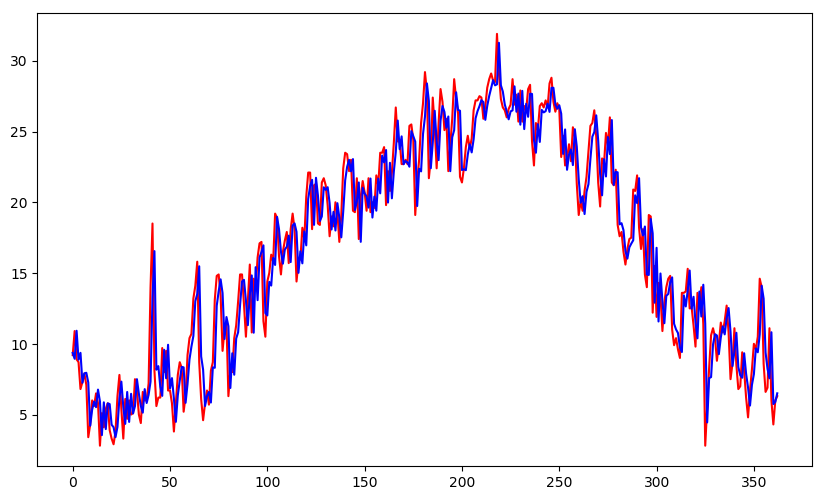

In [574]:
# 학습하기
lr = LinearRegression(normalize=True)
lr.fit(train_x, train_y) # 학습하기
pred_y = lr.predict(test_x) # 예측하기

# 결과를 그래프로 그리기
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(test_y, c='r')
plt.plot(pred_y, c='b')
plt.show()

In [575]:
diff_y = abs(pred_y  - test_y)
print("average=", sum(diff_y) / len(diff_y))
print("max=", max(diff_y))
lr.score(test_x, test_y)

average= 1.689315252873849
max= 8.63207521803523


0.9199006990740651

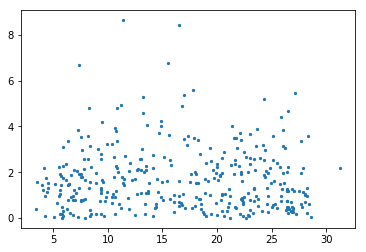

In [576]:
plt.scatter(pred_y, diff_y, s=5)

In [578]:
for i in range(1,12):
    train_x, train_y = make_data(df[train_year_bool], i)
    test_x, test_y = make_data(df[test_year_bool], i)
    lr = LinearRegression(normalize=True)
    lr.fit(train_x, train_y) # 학습하기
    print(i, lr.score(test_x, test_y))

1 0.916555363635416
2 0.9165812019818895
3 0.9199006990740651
4 0.9215274488988293
5 0.9223245451890143
6 0.923475843513415
7 0.924458804907991
8 0.925395183956023
9 0.9248171646161317
10 0.92476342971837
11 0.924513132254838


In [579]:
lr.coef_, lr.intercept_

(array([ 0.01893719,  0.03641349,  0.02213638,  0.0205915 ,  0.02787869,
         0.04557169,  0.02690696,  0.00852789,  0.11283355, -0.14867678,
         0.81603065]), 0.21646522015443637)

## MLP 사용

In [646]:
from numpy import array

# 시리즈 입력, 어레이 리턴
def split_sequence(sequence, n_steps):
  X, y = [], []
  sequence = list(sequence)
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
     break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [647]:
train_year_bool = (df["연"] <= 2015)
test_year_bool = (df["연"] >= 2016)

In [648]:
len(train_year_bool), len(test_year_bool)

(4018, 4018)

In [649]:
n_steps=3
train_s = df[train_year_bool]["기온"]
train_x, train_y = split_sequence(train_s, n_steps)

In [650]:
len(train_x)

3649

In [639]:
test_s = df[test_year_bool]["기온"]

In [651]:
len(test_x)

363

In [652]:
test_x, test_y = split_sequence(test_s, n_steps)

In [653]:
# train_x.shape, train_y.shape
len(train_x), len(test_x)

(3649, 363)

In [654]:
train_x[-10:], train_y[-10:]

(array([[ 7.1,  6.9,  8.8],
        [ 6.9,  8.8, 11. ],
        [ 8.8, 11. ,  6.8],
        [11. ,  6.8, 10.3],
        [ 6.8, 10.3, 10.9],
        [10.3, 10.9,  8.5],
        [10.9,  8.5,  7.3],
        [ 8.5,  7.3,  6. ],
        [ 7.3,  6. ,  6.3],
        [ 6. ,  6.3,  7.2]]),
 array([11. ,  6.8, 10.3, 10.9,  8.5,  7.3,  6. ,  6.3,  7.2,  6.6]))

In [655]:
# train_x=train_x.reshape(-1,n_steps,1)
# test_x=test_x.reshape(-1,n_steps,1)

In [656]:
# define model
from keras import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_steps,))) 
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [657]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_82 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 101       
Total params: 10,601
Trainable params: 10,601
Non-trainable params: 0
_________________________________________________________________


In [658]:
# fit model
model.fit(train_x, train_y, epochs=10, batch_size=50, verbose=0)

In [659]:
yhat = model.predict(test_x, verbose=0)

In [660]:
from sklearn.metrics import r2_score
r2_score(test_y, yhat)

0.9191536387281856

## 리스트와 어레이

In [661]:
x = array([3, 6, 9, 12])
x*3

array([ 9, 18, 27, 36])

In [662]:
x/3

array([1., 2., 3., 4.])

In [663]:
y = [3, 6, 9, 12]
y*3

[3, 6, 9, 12, 3, 6, 9, 12, 3, 6, 9, 12]

In [362]:
y/3

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [365]:
type(x)

numpy.ndarray

In [366]:
type(y)

list

In [367]:
array(y)

array([ 3,  6,  9, 12])

In [370]:
list(x)

[3, 6, 9, 12]

## 리스트와 시리즈

In [383]:
import numpy as np
data = pd.DataFrame(np.arange(12).reshape(3,4), columns=['a','b','c','d'])
data

,a,b,c,d
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


In [385]:
s = data["b"]
s

0    1
1    5
2    9
Name: b, dtype: int64

In [386]:
type(s)

pandas.core.series.Series

In [387]:
s

0    1
1    5
2    9
Name: b, dtype: int64

In [388]:
list(s)

[1, 5, 9]

In [389]:
array(s)

array([1, 5, 9])

In [390]:
x

array([ 3,  6,  9, 12])

In [392]:
new_s = pd.Series(x)

In [393]:
new_s

0     3
1     6
2     9
3    12
dtype: int64

In [394]:
type(new_s)

pandas.core.series.Series

In [398]:
y.append(2)
y

[3, 6, 9, 12, 2, 2]

In [396]:
x.append(2)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [400]:
new_s.append(2)

TypeError: cannot concatenate object of type "<class 'int'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [404]:
x[1:3]

array([6, 9])

In [405]:
y[1:3]

[6, 9]

In [409]:
new_s[0:2]

0    3
1    6
dtype: int64

In [410]:
new_s

0     3
1     6
2     9
3    12
dtype: int64

In [411]:
t = (1,3,5,7,9)
t

(1, 3, 5, 7, 9)

In [412]:
t[0:3]

(1, 3, 5)

In [413]:
list(t)

[1, 3, 5, 7, 9]

In [627]:
# 시리즈 입력, 리스트 리턴
def make_data(data, n_steps):
    x = []
    y = []
    temps = list(data)
    for i in range(len(temps)):
        if i < n_steps: continue
        y.append(temps[i])
        xa = []
        for p in range(n_steps):
            d = i + p - n_steps
            xa.append(temps[d])
        x.append(xa)
    return x, y

In [ ]:
def split_sequence(sequence, n_steps):
  X, y = [], []
  sequence = list(sequence)
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
     break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [624]:
a = [1,2,3,4,5,6,7,8,9,10]
x, y = split_sequence(a,3)
x,y

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]), array([ 4,  5,  6,  7,  8,  9, 10]))

In [628]:
a = pd.Series([1,2,3,4,5,6,7,8,9,10])
x, y = make_data(a,3)
x,y

([[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]],
 [4, 5, 6, 7, 8, 9, 10])